<a href="https://colab.research.google.com/github/enznoor/AnomalyDetection/blob/main/FIP_Libra_Step3_FinalModel_Laplacian_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dgl
!pip install node2vec
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.6 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.2 MB/s eta 0:00:00


In [ ]:
from node2vec.edges import HadamardEmbedder
from gensim.models import Word2Vec
import random
from node2vec import Node2Vec
from gensim.models import KeyedVectors
import torch.optim as optim
import dgl.function as fn
from dgl.nn import SAGEConv

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
from google.colab import drive
import networkx as nx
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
#from dgl.nn import GraphConv
#from dgl.nn import SAGEConv
import dgl.nn as dglnn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score , roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
seed=42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
path='drive/MyDrive/Term_05/FinalProposal/Data/'
Finalpath='drive/MyDrive/Term_05/FinalProposal/FinalData/'
Finalpath_test='drive/MyDrive/Term_05/FinalProposal/FinalData_test/'
pathCommunity='drive/MyDrive/Term_05/FinalProposal/Data/Community/'
train_edge_index=np.load(path+'train_edge_index.npy')
train_edgelist=np.load(path+'train_edgelist.npy')
train_edge_weight=np.load(path+'train_edge_weight.npy')
train_x=np.load(path+'train_x.npy')
train_y=np.load(path+'train_y.npy')
test_edge_index=np.load(path+'test_edge_index.npy')
test_edgelist=np.load(path+'test_edgelist.npy')
test_edge_weight=np.load(path+'test_edge_weight.npy')
test_x=np.load(path+'test_x.npy')
test_y=np.load(path+'test_y.npy')
train_elabel=np.load(path+'edge_y_train.npy')
test_elabel=np.load(path+'edge_y_test.npy')

In [ ]:
nodedf=pd.read_csv(path + 'LibraReduceNodeInfo.csv')
edgedf=pd.read_csv(path + 'LibraReduceEdgeInfo.csv')

In [ ]:
print(edgedf.shape)
print(nodedf.shape)

(370918, 6)
(202426, 22)


In [ ]:
loaded_trainData=np.load(path+'train_node.npy')
loaded_testData=np.load(path+'test_node.npy')
traindf= pd.DataFrame(loaded_trainData, columns=['NewNodeId'])
testdf= pd.DataFrame(loaded_testData, columns=['NewNodeId'])

traindf['NewNodeId'] = traindf['NewNodeId'].astype(int)
traindata_df = pd.merge(traindf,nodedf, on='NewNodeId', how='inner')
testdata_df = pd.merge(testdf,nodedf, on='NewNodeId', how='inner')

In [ ]:
train_idx=torch.tensor(traindata_df.index, dtype = torch.long)
test_idx=torch.tensor(testdata_df.index, dtype = torch.long)
#valid_idx=torch.tensor(validate.index, dtype = torch.long)

In [ ]:
edgedf.insert(1, "elabel", 0)
edgedf["elabel"] = np.where(edgedf["nr_alerts"] > 0, 1, 0)

In [ ]:
AttrEge=['cum_amount', 'nr_transactions' ,'elabel' ]
G=nx.from_pandas_edgelist(
            df=edgedf,
            source="id_source",
            target="id_destination",
            edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges: ',G.number_of_edges())
print('number_of_nodes: ',G.number_of_nodes())

number_of_edges:  370918
number_of_nodes:  202426


# Create Train and Test Graph for edge Classification

In [ ]:
df1=pd.DataFrame(train_edgelist)
df2=pd.DataFrame(train_edge_weight)
train_edgelist_G=pd.merge(df1,df2,left_index=True, right_index=True)
#-------------------------------------------------------------------------------
train_edgelist_G = train_edgelist_G.rename(columns={'0_x': 'id_source'})
train_edgelist_G = train_edgelist_G.rename(columns={'1_x': 'id_destination'})
train_edgelist_G = train_edgelist_G.rename(columns={'0_y': 'cum_amount'})
train_edgelist_G = train_edgelist_G.rename(columns={'1_y': 'nr_transactions'})
train_edgelist_G['eLabel']=pd.DataFrame(train_elabel)

In [ ]:
AttrEge=['cum_amount', 'nr_transactions' ]
train_G=nx.from_pandas_edgelist(
            df=train_edgelist_G,
            source="id_source",
            target="id_destination",
            edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges: ',train_G.number_of_edges())
print('number_of_nodes: ',train_G.number_of_nodes())

number_of_edges:  230907
number_of_nodes:  135447


In [ ]:
df1=pd.DataFrame(test_edgelist)
df2=pd.DataFrame(test_edge_weight)
test_edgelist_G=pd.merge(df1,df2,left_index=True, right_index=True)
#-------------------------------------------------------------------------------
test_edgelist_G = test_edgelist_G.rename(columns={'0_x': 'id_source'})
test_edgelist_G = test_edgelist_G.rename(columns={'1_x': 'id_destination'})
test_edgelist_G = test_edgelist_G.rename(columns={'0_y': 'cum_amount'})
test_edgelist_G = test_edgelist_G.rename(columns={'1_y': 'nr_transactions'})
test_edgelist_G['eLabel']=pd.DataFrame(test_elabel)

In [ ]:
AttrEge=['cum_amount', 'nr_transactions' ]
test_G=nx.from_pandas_edgelist(
            df=test_edgelist_G,
            source="id_source",
            target="id_destination",
            edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges: ',test_G.number_of_edges())
print('number_of_nodes: ',test_G.number_of_nodes())

number_of_edges:  16222
number_of_nodes:  12963


In [ ]:
#train_G = G.subgraph(loaded_trainData)
#test_G = G.subgraph(loaded_testData)
print('number_of_edges train_graph: ',train_G.number_of_edges())
print('number_of_nodes train_graph: ',train_G.number_of_nodes())
print('number_of_edges test_graph: ',test_G.number_of_edges())
print('number_of_nodes test_graph: ',test_G.number_of_nodes())


number_of_edges train_graph:  230907
number_of_nodes train_graph:  135447
number_of_edges test_graph:  16222
number_of_nodes test_graph:  12963


# Set Attribute  to Train and Test Graph

In [ ]:
trainNode_G=list(train_G.nodes())
trainNode=pd.DataFrame(trainNode_G, columns=['NewNodeId'])
traindata_df = pd.merge(trainNode,nodedf, on='NewNodeId', how='inner')

testNode_G=list(test_G.nodes())
testNode=pd.DataFrame(testNode_G, columns=['NewNodeId'])
testdata_df = pd.merge(testNode,nodedf, on='NewNodeId', how='inner')

In [ ]:
col=['NewNodeId']
df1=traindata_df[col].where(traindata_df['L_alert'] ==1).dropna()
df2=testdata_df[col].where(testdata_df['L_alert'] ==1).dropna()
ListAnomalNode_train=df1['NewNodeId'].values.tolist()
ListAnomalNode_test=df2['NewNodeId'].values.tolist()

In [ ]:
len(ListAnomalNode_test)

74

# Community Detection For Train and Test Graph

In [ ]:
from networkx.algorithms.community import louvain_communities

In [ ]:
partitions_TG=louvain_communities(train_G)
print('partitions number of train:',len(partitions_TG))

partitions_TST=louvain_communities(test_G)
print('partitions number of test:',len(partitions_TST))

partitions number of train: 13867
partitions number of test: 2102


In [ ]:
def Get_partitionList(partitions ,G , ListAnomalNode,df):
    partitions_List=[]
    for index , community  in enumerate(partitions):
        #-------------Get Anomal Node--------------
        CntAnomalNode=0
        Label=0
        for i in ListAnomalNode:
            if i in community:
                CntAnomalNode=CntAnomalNode+1
        if  CntAnomalNode>0:
            Label=1
        #CM_Dictionary= [index , len(CM) , CntAnomalNode ]
        #------------------------------------------
        val_amount_out=Get_FinancialFlow(community,'f_amount_out',df)
        val_amount_in=Get_FinancialFlow(community,'f_amount_in',df)
        val_nr_trans_in=Get_FinancialFlow(community,'f_nr_trans_in',df)
        val_nr_trans_out=Get_FinancialFlow(community,'f_nr_trans_out',df)

        item=[index,community,len(community),CntAnomalNode,val_amount_in,val_amount_out,val_nr_trans_in,val_nr_trans_out,Label]
        partitions_List.append(item)
    return partitions_List

In [ ]:
for i, community in enumerate(partitions_TG):
    if len(community)>1000:
        print(i,community)

62 {106497, 192514, 155650, 45060, 20481, 147467, 18, 106515, 98324, 45076, 45082, 110621, 114718, 98335, 45096, 151592, 155702, 147510, 73782, 4150, 172093, 151614, 81985, 86087, 180305, 131153, 176209, 20562, 36951, 61539, 20579, 127080, 188532, 196730, 188538, 172156, 16510, 139415, 155802, 98460, 102557, 12454, 131245, 16559, 61618, 159927, 32952, 151738, 114879, 94403, 139462, 199, 143561, 102605, 155863, 123109, 188647, 188660, 28919, 57592, 180475, 123131, 180476, 8447, 28928, 143619, 82180, 151813, 69894, 151816, 188685, 45338, 106782, 176417, 45346, 188708, 201014, 147769, 45373, 16702, 98623, 172352, 37183, 318, 65856, 184646, 172358, 164169, 33098, 334, 37198, 78161, 94546, 102744, 4440, 24929, 110946, 119144, 69993, 131434, 176493, 29039, 65906, 119162, 196987, 151942, 65928, 45452, 94604, 4494, 164241, 164244, 160151, 98713, 176544, 131491, 49573, 53678, 70064, 151985, 438, 70075, 160191, 201155, 82376, 94671, 70100, 102871, 106969, 180698, 20956, 37342, 61922, 139754, 123

In [ ]:
c=0
for i in ListAnomalNode_test:
    for node in test_G.nodes():
        if node==i:
            #print(node)
            c=c+1
print(c)


74


In [ ]:
def Get_FinancialFlow(NodeList,featurename,df):
    filtered_df = df[df['NewNodeId'].isin(NodeList)]
    sumofvalue=filtered_df[featurename].sum()
    #print(sumofvalue)

    return sumofvalue

In [ ]:
def Get_CommunityID(node , membership):
    for index , item in enumerate(membership):
        CMIndex=membership[index][0]
        CMNode=membership[index][1]
        if node in CMNode:
            break
    return CMIndex

In [ ]:
def Get_edgeList(DF_partitions_List,G):
    ColumnName=['Index','Nodelist']
    membership=list(DF_partitions_List[ColumnName].to_numpy())
    edglistem=[]
    cnt=0
    for node1,node2 in G.edges:
        CMIndex_node1=Get_CommunityID(node1 , membership)
        CMIndex_node2=Get_CommunityID(node2, membership)
        if CMIndex_node1 != CMIndex_node2:
            edgeitem=[CMIndex_node1 , CMIndex_node2]
            edglistem.append(edgeitem)
            cnt=cnt+1
            if cnt % 20 == 0:
                print(f" count of Edge:  {cnt}, Total: {len(membership)})"
                )
    #-----------------------------------------------
    columnname=['source_id','destination_id']
    DF_AccGrpEdge=pd.DataFrame(edglistem ,  columns=columnname)
    return DF_AccGrpEdge

In [ ]:
#DF_partitions_List_TG['Nodelist'][1]

{33395, 168146}

In [ ]:
partitions_List_tst=Get_partitionList(partitions_TST ,test_G , ListAnomalNode_test, testdata_df)
#columnname=['Index','Nodelist' ,'Subgraph' ,'subgraph_embedding','Laplacian' , 'embedded_Laplacian','len_Community' , 'CntAnomalNode','f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out','Label']
columnname=['Index','Nodelist' , 'len_Community' , 'CntAnomalNode','f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out','Label']
DF_partitions_List_TST=pd.DataFrame(partitions_List_tst ,  columns=columnname)
DF_partitions_List_TST.to_csv(Finalpath +  'partitions_List_TST.csv', index=False)

In [ ]:
partitions_List_TG=Get_partitionList(partitions_TG ,train_G , ListAnomalNode_train, traindata_df)
DF_partitions_List_TG=pd.DataFrame(partitions_List_TG ,  columns=columnname)
DF_partitions_List_TG.to_csv(Finalpath +  'partitions_List_TR.csv', index=False)

In [ ]:
DF_AccGrpEdge_TST=Get_edgeList(DF_partitions_List_TST,test_G)
DF_AccGrpEdge_TST.to_csv(Finalpath +  'AccGrpEdge_test.csv', index=False)
DF_AccGrpEdge_TR=Get_edgeList(DF_partitions_List_TG,train_G)
DF_AccGrpEdge_TR.to_csv(Finalpath +  'AccGrpEdge_train.csv', index=False)

In [ ]:
#unique_df = DF_AccGrpEdge.drop_duplicates()

In [ ]:
# c=0
# for i in ListAnomalNode_test:
#     for node in test_G.nodes():
#         if node==i:
#             print(node)
# print(c)

# Create AccGrp Graph

In [ ]:
train_Grpedgedf=pd.read_csv(Finalpath + 'AccGrpEdge_train.csv')
test_Grpedgedf=pd.read_csv(Finalpath + 'AccGrpEdge_test.csv')

train_partitiondf=pd.read_csv(Finalpath + 'partitions_List_TR.csv')
test_partitiondf=pd.read_csv(Finalpath + 'partitions_List_TST.csv')

In [ ]:
print('train_partitiondf:',len(train_partitiondf))
print('test_partitiondf', len(test_partitiondf))

train_partitiondf: 13767
test_partitiondf 2098


In [ ]:
#AttrEge=['cum_amount', 'nr_transactions']
Grp_Train_G=nx.from_pandas_edgelist(
            df=train_Grpedgedf,
            source="source_id",
            target="destination_id",
            #edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges for train graph: ',Grp_Train_G.number_of_edges())
print('number_of_nodes for train graph: ',Grp_Train_G.number_of_nodes())

number_of_edges for train graph:  80846
number_of_nodes for train graph:  11419


In [ ]:
#AttrEge=['cum_amount', 'nr_transactions']
Grp_Test_G=nx.from_pandas_edgelist(
            df=test_Grpedgedf,
            source="source_id",
            target="destination_id",
            #edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges for test graph: ',Grp_Test_G.number_of_edges())
print('number_of_nodes for test graph: ',Grp_Test_G.number_of_nodes())

number_of_edges for test graph:  3818
number_of_nodes for test graph:  1252


In [ ]:
nodelist=Grp_Train_G.nodes()
for node in list(train_partitiondf['Index'].to_numpy()):
    if node not in nodelist:
        Grp_Train_G.add_edge(node,node)
        #print(node)

In [ ]:
#-----------------------------------------------------------------
nodelist=Grp_Test_G.nodes()
for node in list(test_partitiondf['Index'].to_numpy()):
    if node not in nodelist:
        Grp_Test_G.add_edge(node,node)
        #print(node)


In [ ]:
print('number_of_edges: ',Grp_Train_G.number_of_edges())
print('number_of_nodes: ',Grp_Train_G.number_of_nodes())
print('----------------------------------------------')
print('number_of_edges: ',Grp_Test_G.number_of_edges())
print('number_of_nodes: ',Grp_Test_G.number_of_nodes())

number_of_edges:  83194
number_of_nodes:  13767
----------------------------------------------
number_of_edges:  4664
number_of_nodes:  2098


In [ ]:
# Grp_train_graph=dgl.DGLGraph(Grp_Train_G)
# Grp_test_graph=dgl.DGLGraph(Grp_Test_G)

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


# Subgraph Embedding and Laplacian Embedding For Feature AccNode Graph

In [ ]:
def embedding_Subgraph(subgraph, dim):
    node2vec = Node2Vec(subgraph, dimensions=dim)
    # Embed nodes
    modelTG = node2vec.fit(window=10, min_count=1, batch_words=4)
    embeddings = modelTG.wv
    node_embeddingslist = embeddings.vectors.tolist()
    subgraph_embedding = np.mean(node_embeddingslist, axis=0)
    #subgraph_embedding=torch.tensor(subgraph_embedding , dtype = torch.float)
    return subgraph_embedding

In [ ]:
from sklearn.manifold import TSNE

def embedding_Laplacian(matrix, n_components=2 , perplexity=1):
    inputmatrix=np.asarray(matrix)
    learning_rate=0.2
    n_iter=250
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    embedded_matrix = tsne.fit_transform(inputmatrix)
    return embedded_matrix

In [ ]:
def Get_SubgraphEmbedding(partitions ,G ):
    Embedding_List=[]
    cnt=0
    for index , community  in enumerate(partitions):
        subgraph = G.subgraph(community)
        A = nx.adjacency_matrix(subgraph)
        degrees = np.sum(A, axis=1)
        D = np.diag(degrees)
        L = D - A
        #------------------------------------------embedding SubGraph-------------------------------------------
        subgraph_embedding =embedding_Subgraph(subgraph,2)
        #-------------------------------------------------------------------------------------------------------
        embedded_L=embedding_Laplacian(L)
        embedded_Laplacian=np.mean(embedded_L, axis=0)
        item=[index,community,subgraph,subgraph_embedding[0],subgraph_embedding[1],embedded_Laplacian[0],embedded_Laplacian[1],len(community)]
        Embedding_List.append(item)
        cnt=cnt+1
        if cnt % 20 == 0:
            print('---------------------------------------------------------------')
            print(f" count of Edge:  {cnt}, Total: {len(partitions)})"
                 )
            print('---------------------------------------------------------------')
    return Embedding_List

In [ ]:
for index , community  in enumerate(partitions_TST):
    if index==170:
        subgraph = test_G.subgraph(community)

In [ ]:
plt.figure(figsize=(6, 4))
nx.draw(subgraph, with_labels=True, node_color='lightblue', font_weight='bold')
plt.title('Subgraph')
plt.show()

In [ ]:
subgraph_embedding =embedding_Subgraph(subgraph,2)

Computing transition probabilities:   0%|          | 0/13 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 5277.85it/s]


In [ ]:
columnname=['Index','Nodelist' ,'Subgraph' ,'subgraph_embedding_0','subgraph_embedding_1', 'embedded_Laplacian_0' ,'embedded_Laplacian_1', 'communitySize']
Embedding_List_tst=Get_SubgraphEmbedding(partitions_TST ,test_G)
DF_Embedding_List_TST=pd.DataFrame(Embedding_List_tst ,  columns=columnname)
DF_Embedding_List_TST.to_csv(Finalpath +  'Embedding_List_TST.csv', index=False)

In [ ]:
Embedding_List_TR=Get_SubgraphEmbedding(partitions_TG ,train_G)
DF_Embedding_List_TR=pd.DataFrame(Embedding_List_TR ,  columns=columnname)
DF_Embedding_List_TR.to_csv(Finalpath +  'Embedding_List_TR.csv', index=False)

In [ ]:
# def str_to_list(s):
#     # Remove curly braces and split by comma
#     s = s.strip('{}').split(',')
#     # Convert each element to an integer
#     return [int(x) for x in s]

# newlist=[]
# for _, row in test_df.iterrows():
#     CMNode=str_to_list(row['subgraph_embedding'])
#     CMIndex=row['Index']
#     itm=[CMNode,CMIndex]
#     newlist.append(itm)



#Prepare Feature for Training and Test

In [ ]:
train_embeddingdf=pd.read_csv(Finalpath + 'Embedding_List_TR.csv')
test_embeddingdf=pd.read_csv(Finalpath + 'Embedding_List_TST.csv')

In [ ]:
columnname=['Index','subgraph_embedding_0','subgraph_embedding_1','embedded_Laplacian_0','embedded_Laplacian_1']
test_Embedding_List_df=pd.read_csv(Finalpath + 'Embedding_List_TST.csv')
test_Embedding_List_df=test_Embedding_List_df[columnname]
Feature_test_df = pd.merge(test_Embedding_List_df,test_partitiondf, on='Index', how='inner')
FeaturName=['Index','subgraph_embedding_0','subgraph_embedding_1','embedded_Laplacian_0','embedded_Laplacian_1','f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out']
#Feature_test_df['subgraph_embedding'] = Feature_test_df.apply(lambda row: [row['subgraph_embedding_0'], row['subgraph_embedding_1']], axis=1)
#Feature_test_df['embedded_Laplacian'] = Feature_test_df.apply(lambda row: [row['embedded_Laplacian_0'], row['embedded_Laplacian_1']], axis=1)
#Feature_test_df['Financial'] = Feature_test_df.apply(lambda row: [row['f_amount_in'], row['f_amount_out']], axis=1)
#Feature_test_df['Transactiion'] = Feature_test_df.apply(lambda row: [row['f_nr_trans_in'], row['f_nr_trans_out']], axis=1)
#Col_Feature_Final=['subgraph_embedding','embedded_Laplacian','Financial','Transactiion']
Col_Feature_Final=[ 'embedded_Laplacian_0','embedded_Laplacian_1']
F_TST_df=Feature_test_df[Col_Feature_Final]
Grp_X_test=torch.tensor(F_TST_df.values.tolist(), dtype=torch.float)
Grp_y_test=torch.tensor((Feature_test_df['Label'].values).tolist(), dtype=torch.long)

In [ ]:
train_Embedding_List_df=pd.read_csv(Finalpath + 'Embedding_List_TR.csv')
train_Embedding_List_df=train_Embedding_List_df[columnname]
Feature_train_df = pd.merge(train_Embedding_List_df,train_partitiondf, on='Index', how='inner')
FeaturName=['Index','subgraph_embedding_0','subgraph_embedding_1','embedded_Laplacian_0','embedded_Laplacian_1','f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out']
#Feature_train_df['subgraph_embedding'] = Feature_train_df.apply(lambda row: [row['subgraph_embedding_0'], row['subgraph_embedding_1']], axis=1)
#Feature_train_df['embedded_Laplacian'] = Feature_train_df.apply(lambda row: [row['embedded_Laplacian_0'], row['embedded_Laplacian_1']], axis=1)
#Feature_train_df['Financial'] = Feature_train_df.apply(lambda row: [row['f_amount_in'], row['f_amount_out']], axis=1)
#Feature_train_df['Transactiion'] = Feature_train_df.apply(lambda row: [row['f_nr_trans_in'], row['f_nr_trans_out']], axis=1)
#Col_Feature_Final=['subgraph_embedding','embedded_Laplacian','Financial','Transactiion']
Col_Feature_Final=[ 'embedded_Laplacian_0','embedded_Laplacian_1']
F_TR_df=Feature_train_df[Col_Feature_Final]
Grp_X_train=torch.tensor(F_TR_df.values.tolist(), dtype=torch.float)
Grp_y_train=torch.tensor((Feature_train_df['Label'].values).tolist(), dtype=torch.long)

In [ ]:
# SubgraphList=[]
# for _, row in Feature_test_df.iterrows():
#     item=[row['subgraph_embedding_0'], row['subgraph_embedding_1']]
#     SubgraphList.append(item)

In [ ]:
# def save_embeddings(embeddings, filename):
#     with open(filename, 'w') as f:
#         num_embeddings, embedding_dim = len(embeddings), len(embeddings[0])
#         f.write(f"{num_embeddings} {embedding_dim}\n")
#         for i, emb in enumerate(embeddings):
#             word = f"word{i}"  # Generating a placeholder word
#             emb_str = " ".join(str(x) for x in emb)
#             f.write(f"{word} {emb_str}\n")
# save_embeddings(SubgraphList, Finalpath+"embeddings_sub.emb")
# SubgraphList_emb=KeyedVectors.load_word2vec_format(Finalpath +  'embeddings_sub.emb')
# node_embeddingslist = SubgraphList_emb.vectors.tolist()

In [ ]:
Grp_X_train.shape

torch.Size([13767, 2])

# Community Info

In [ ]:
condition = train_partitiondf['Label'] ==1
rows_count = len(train_partitiondf[condition])
print('count ot anomal community for train data:',rows_count)
condition = test_partitiondf['Label'] ==1
rows_count = len(test_partitiondf[condition])
print('count ot anomal community for test data:',rows_count)


count ot anomal community for train data: 227
count ot anomal community for test data: 57


In [ ]:
PartInfo=train_embeddingdf.values.tolist()

In [ ]:
def Plot_community(CommunityID):
    subgraph_nodes = set(map(int, PartInfo[CommunityID][1].strip('{}').split(',')))
    subgraph=train_G.subgraph(subgraph_nodes)
    condition_column='NewNodeId'
    condition_value=subgraph_nodes
    selected_rows = nodedf[nodedf[condition_column].isin(subgraph_nodes)]
    labels_list = selected_rows['L_alert'].values.tolist()
    labels_dict = {node: label for node, label in zip(subgraph.nodes, labels_list)}
    nx.set_node_attributes(subgraph, labels_dict, 'label')
    node_colors = {1: 'red', 0: 'blue'}
    colors = [node_colors[subgraph.nodes[node]['label']] for node in subgraph.nodes]
    pos = nx.spring_layout(subgraph)  # Positions for all nodes
    nx.draw(subgraph, pos, node_color=colors, with_labels=False, node_size=100)
    plt.show()
    print('Number of Node in community: ', len(subgraph_nodes))





In [ ]:
subgraph_nodes = set(map(int, PartInfo[3764][1].strip('{}').split(',')))
subgraph=train_G.subgraph(subgraph_nodes)

In [ ]:
condition_column='NewNodeId'
condition_value=subgraph_nodes
#filtered_df =  nodedf[nodedf[condition_column].apply(lambda x: isinstance(subgraph_nodes, set))]
selected_rows = nodedf[nodedf[condition_column].isin(subgraph_nodes)]

In [ ]:
labels_list = selected_rows['L_alert'].values.tolist()
labels_dict = {node: label for node, label in zip(subgraph.nodes, labels_list)}

In [ ]:
nx.set_node_attributes(subgraph, labels_dict, 'label')

In [ ]:
# for node in subgraph.nodes:
#     print(subgraph.nodes[node]['label'])

In [ ]:
node_colors = {1: 'red', 0: 'blue'}
colors = [node_colors[subgraph.nodes[node]['label']] for node in subgraph.nodes]

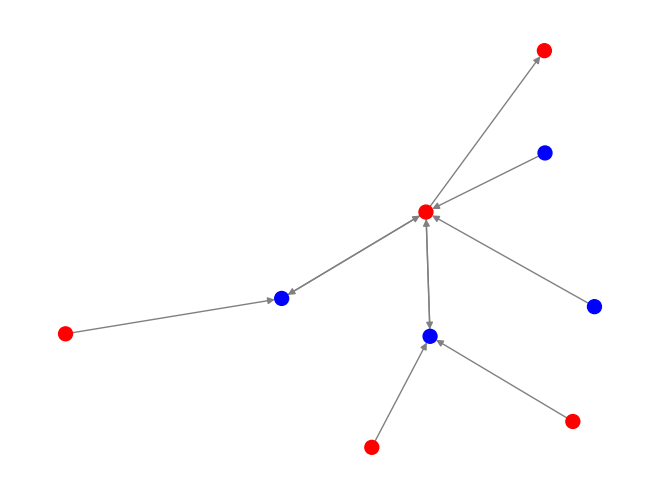

In [ ]:
pos = nx.spring_layout(subgraph )  # Positions for all nodes
nx.draw(subgraph, pos, node_color=colors, with_labels=False , font_weight='bold', node_size=100, font_size=12, edge_color='gray', width=1)
plt.show()

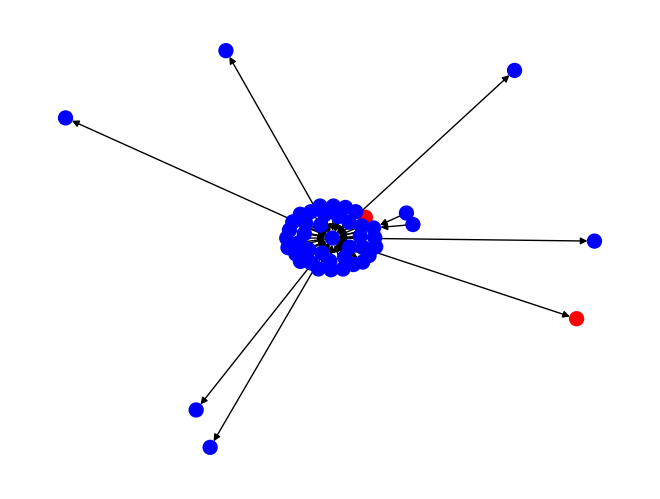

Number of Node in community:  48


In [ ]:
Plot_community(1980)

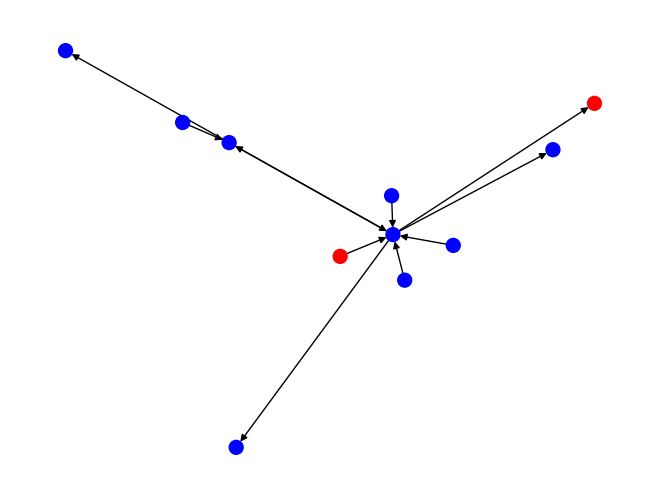

Number of Node in community:  11


In [ ]:
Plot_community(1803)

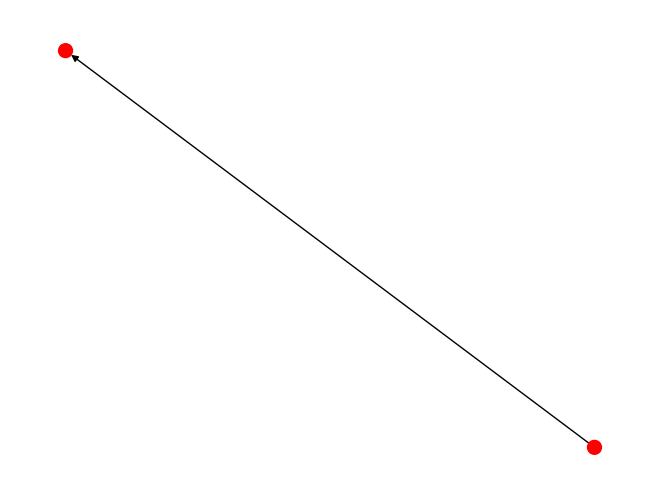

Number of Node in community:  2


In [ ]:
Plot_community(261)

# ACCGroup prediction with Laplacian Feature

In [ ]:
class Grp_Autoencoder(nn.Module):
    def __init__(self):
        super(Grp_Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            #nn.Linear(64, 32),
            #nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            #nn.Linear(32, 64),
            #nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()  # Sigmoid for output between 0 and 1
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
Grp_class_weights=Get_class_weights(Grp_y_train)

In [ ]:
import tensorflow as tf
seed=42
learning_rate_Grp=0.2
batch_size_Grp =len(Grp_X_train)
batch_size_Grp_tst =len(Grp_X_test)
epochs=80
input_dim=Grp_X_train.shape[1]
tf.random.set_seed(42)
autoencoder = Grp_Autoencoder()
classifier = Classifier(autoencoder.encoder)
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
train_dateset=torch.utils.data.TensorDataset(Grp_X_train,Grp_y_train)
train_loader_Grp=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_Grp, shuffle=True)


test_dataset=torch.utils.data.TensorDataset(Grp_X_test,Grp_y_test)
test_loader_Grp=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_Grp_tst, shuffle=False )

In epoch 0, loss: 0.719)
In epoch 5, loss: 0.698)
In epoch 10, loss: 0.689)
In epoch 15, loss: 0.676)
In epoch 20, loss: 0.658)
In epoch 25, loss: 0.651)
In epoch 30, loss: 0.645)
In epoch 35, loss: 0.642)
In epoch 40, loss: 0.637)
In epoch 45, loss: 0.639)
In epoch 50, loss: 0.643)
In epoch 55, loss: 0.641)
In epoch 60, loss: 0.636)
In epoch 65, loss: 0.637)
In epoch 70, loss: 0.639)
In epoch 75, loss: 0.635)


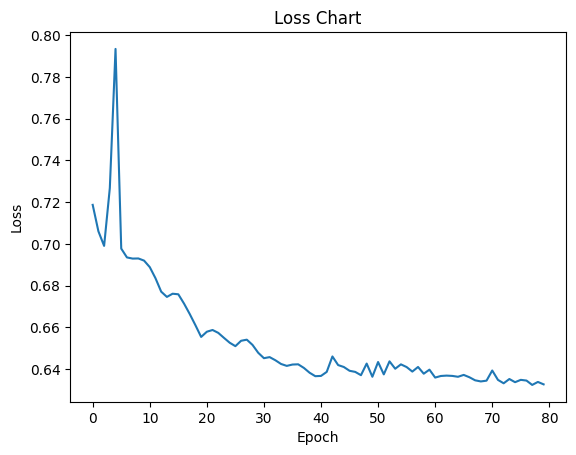

In [ ]:
torch.backends.cudnn.deterministic = True
Grp_model=train(model=classifier, train_loader=train_loader_Grp, epochs=epochs , class_weights=Grp_class_weights , learning_rate=learning_rate_Grp)

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      2041
           1       0.07      0.25      0.11        57

    accuracy                           0.89      2098
   macro avg       0.52      0.58      0.52      2098
weighted avg       0.95      0.89      0.92      2098



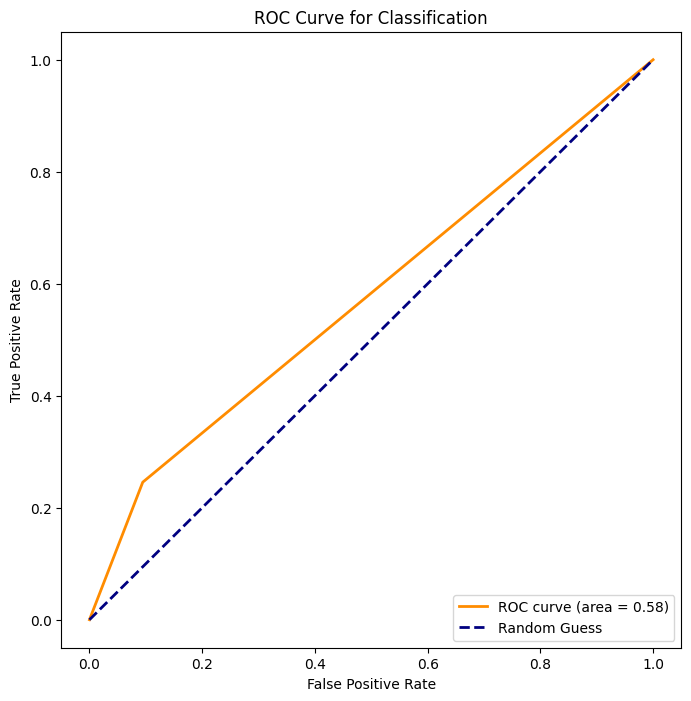

0.8875119090080261

In [ ]:
evaluate(model=Grp_model, test_loader=test_loader_Grp)

# AccGrp embedding  and Predict With Financial data

In [ ]:
node2vec = Node2Vec(Grp_Train_G, dimensions=2)
# Embed nodes
modelTG = node2vec.fit(window=10, min_count=1, batch_words=4)
embeddings = modelTG.wv

modelTG.wv.save_word2vec_format(Finalpath +  'EMBEDDING_Train_AccGrp.emb')

Computing transition probabilities:   0%|          | 0/13767 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


In [ ]:
modelTG.save(Finalpath +'modelTsTG_Train_AccGrp.wv')

In [ ]:
node2vec = Node2Vec(Grp_Test_G, dimensions=2)
# Embed nodes
modelTstG = node2vec.fit(window=10, min_count=1, batch_words=4)
embeddings = modelTstG.wv

modelTstG.wv.save_word2vec_format(Finalpath +  'EMBEDDING_Test_AccGrp.emb')

Computing transition probabilities:   0%|          | 0/2098 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


In [ ]:
modelTstG.save(Finalpath +'modelTstG_test_AccGrp.wv')

In [ ]:
#---------------------Load Data Model -------------------------------------------------
train_node_embeddings =KeyedVectors.load_word2vec_format(path +  'EMBEDDING_Train_AccGrp.emb')
Train_model = Word2Vec.load(Finalpath + 'modelTsTG_Train_AccGrp.wv')
test_node_embeddings =KeyedVectors.load_word2vec_format(path +  'EMBEDDING_Test_AccGrp.emb')
Test_model = Word2Vec.load(Finalpath + 'modelTstG_test_AccGrp.wv')

In [ ]:
train_embeddings=Train_model.wv
node_embeddingslist = train_embeddings.vectors.tolist()
node_features_train=torch.tensor(node_embeddingslist , dtype = torch.float)

test_embeddings=Test_model.wv
node_embeddingslist = test_embeddings.vectors.tolist()
node_features_test=torch.tensor(node_embeddingslist , dtype = torch.float)

In [ ]:
Col_Feature_Final=['f_amount_in','f_amount_out']
#Feature_test_df[Col_Feature_Final]

In [ ]:
# Grp_X_train=node_features_train
# Grp_y_train= torch.tensor((train_partitiondf['Label'].values).tolist(), dtype=torch.long)
# Grp_X_test=node_features_test
# Grp_y_test=torch.tensor((test_partitiondf['Label'].values).tolist(), dtype=torch.long)

In [ ]:
#featurename=['len_Community' ,'f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out']
#featurename=['f_amount_in','f_amount_out', 'f_nr_trans_in','f_nr_trans_out']
Grp_X_train=torch.tensor((Feature_train_df[Col_Feature_Final].values).tolist(), dtype=torch.float)
Grp_X_test =torch.tensor((Feature_test_df[Col_Feature_Final].values).tolist(), dtype=torch.float)
#Grp_X_train=torch.tensor(node_features_train)
#Grp_X_test=torch.tensor(node_features_test)
Grp_y_train=torch.tensor((Feature_train_df['Label'].values).tolist(), dtype=torch.long)
Grp_y_test=torch.tensor((Feature_test_df['Label'].values).tolist(), dtype=torch.long)

In [ ]:
# listfeaturel_test=(Feature_test_df[Col_Feature_Final].values).tolist()

# merged_featurelist_test = []
# for item1, item2 in zip(listfeaturel_test, node_features_test.tolist()):
#     merged_item = item1 + item2  # Concatenate the lists
#     merged_featurelist_test.append(merged_item)


# listfeaturel_train=(Feature_train_df[Col_Feature_Final].values).tolist()
# merged_featurelist_train = []
# for item1, item2 in zip(listfeaturel_train, node_features_train.tolist()):
#     merged_item = item1 + item2  # Concatenate the lists
#     merged_featurelist_train.append(merged_item)

# #-------------------------------------------------------------------------------------------
# Grp_X_train=torch.tensor( merged_featurelist_train, dtype=torch.float)
# Grp_X_test =torch.tensor(merged_featurelist_test, dtype=torch.float)


In [ ]:
class Grp_Classifier(nn.Module):
    def __init__(self, encoder):
        super(Grp_Classifier, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(16, 2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        return x

In [ ]:
class Grp_Autoencoder(nn.Module):
    def __init__(self):
        super(Grp_Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            #nn.Linear(64, 32),
            #nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            #nn.Linear(64, 32),
            #nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()  # Sigmoid for output between 0 and 1
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
Grp_class_weights=Get_class_weights(Grp_y_train)

In [ ]:
import tensorflow as tf
seed=42
learning_rate_Grp=0.003
batch_size_Grp =len(Grp_X_train)
batch_size_Grp_tst =len(Grp_X_test)
epochs=80
input_dim=Grp_X_train.shape[1]
tf.random.set_seed(42)
autoencoder = Grp_Autoencoder()
classifier = Grp_Classifier(autoencoder.encoder)
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
train_dateset=torch.utils.data.TensorDataset(Grp_X_train,Grp_y_train)
train_loader_Grp=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_Grp, shuffle=True)


test_dataset=torch.utils.data.TensorDataset(Grp_X_test,Grp_y_test)
test_loader_Grp=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_Grp_tst, shuffle=False )

In [ ]:
torch.backends.cudnn.deterministic = True
Grp_model=train(model=classifier, train_loader=train_loader_Grp, epochs=epochs , class_weights=Grp_class_weights , learning_rate=learning_rate_Grp)

              precision    recall  f1-score   support

           0       0.98      0.86      0.91      2041
           1       0.07      0.39      0.12        57

    accuracy                           0.84      2098
   macro avg       0.53      0.62      0.52      2098
weighted avg       0.96      0.84      0.89      2098



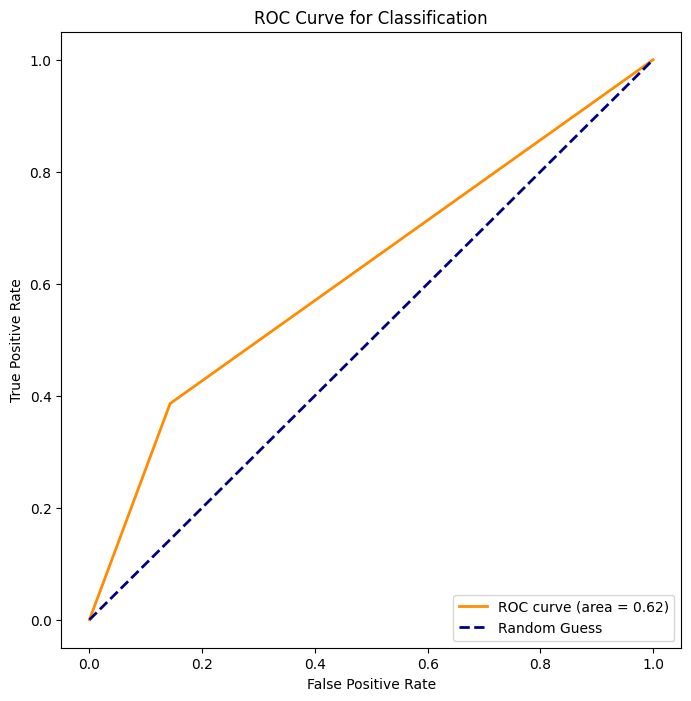

0.8441372513771057

In [ ]:
evaluate(model=Grp_model, test_loader=test_loader_Grp)

# ACCGroup prediction with Subgraph embedding Feature

In [ ]:
columnname=['Index','subgraph_embedding_0','subgraph_embedding_1','embedded_Laplacian_0','embedded_Laplacian_1']
test_Embedding_List_df=pd.read_csv(Finalpath + 'Embedding_List_TST.csv')
test_Embedding_List_df=test_Embedding_List_df[columnname]
Feature_test_df = pd.merge(test_Embedding_List_df,test_partitiondf, on='Index', how='inner')
Col_Feature_Final=['subgraph_embedding_0','subgraph_embedding_1']
F_TST_df=Feature_test_df[Col_Feature_Final]
Grp_X_test=torch.tensor(F_TST_df.values.tolist(), dtype=torch.float)
Grp_y_test=torch.tensor((Feature_test_df['Label'].values).tolist(), dtype=torch.long)

F_TR_df=Feature_train_df[Col_Feature_Final]
Grp_X_train=torch.tensor(F_TR_df.values.tolist(), dtype=torch.float)
Grp_y_train=torch.tensor((Feature_train_df['Label'].values).tolist(), dtype=torch.long)

In [ ]:
class SubG_Classifier(nn.Module):
    def __init__(self, encoder):
        super(SubG_Classifier, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(16, 2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        return x

In [ ]:
class SubG_Autoencoder(nn.Module):
    def __init__(self):
        super(SubG_Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            #nn.Linear(64, 32),
            #nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            #nn.Linear(32, 64),
            #nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()  # Sigmoid for output between 0 and 1
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
SubG_class_weights=Get_class_weights(Grp_y_train)

In [ ]:
import tensorflow as tf
seed=42
learning_rate_Grp=0.09
batch_size_Grp =len(Grp_X_train)
batch_size_Grp_tst =len(Grp_X_test)
epochs=80
input_dim=Grp_X_train.shape[1]
tf.random.set_seed(42)
autoencoder = SubG_Autoencoder()
classifier = SubG_Classifier(autoencoder.encoder)
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
train_dateset=torch.utils.data.TensorDataset(Grp_X_train,Grp_y_train)
train_loader_Grp=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_Grp, shuffle=True)


test_dataset=torch.utils.data.TensorDataset(Grp_X_test,Grp_y_test)
test_loader_Grp=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_Grp_tst, shuffle=False )

In epoch 0, loss: 0.695)
In epoch 5, loss: 0.691)
In epoch 10, loss: 0.671)
In epoch 15, loss: 0.660)
In epoch 20, loss: 0.651)
In epoch 25, loss: 0.646)
In epoch 30, loss: 0.640)
In epoch 35, loss: 0.641)
In epoch 40, loss: 0.634)
In epoch 45, loss: 0.629)
In epoch 50, loss: 0.625)
In epoch 55, loss: 0.622)
In epoch 60, loss: 0.621)
In epoch 65, loss: 0.620)
In epoch 70, loss: 0.619)
In epoch 75, loss: 0.618)


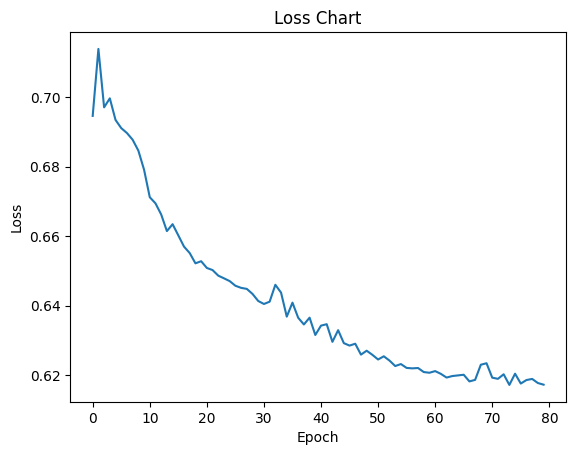

In [ ]:
torch.backends.cudnn.deterministic = True
SubGGrp_model=train(model=classifier, train_loader=train_loader_Grp, epochs=epochs , class_weights=SubG_class_weights , learning_rate=learning_rate_Grp)

              precision    recall  f1-score   support

           0       0.98      0.76      0.86      2041
           1       0.05      0.46      0.09        57

    accuracy                           0.76      2098
   macro avg       0.52      0.61      0.48      2098
weighted avg       0.96      0.76      0.84      2098



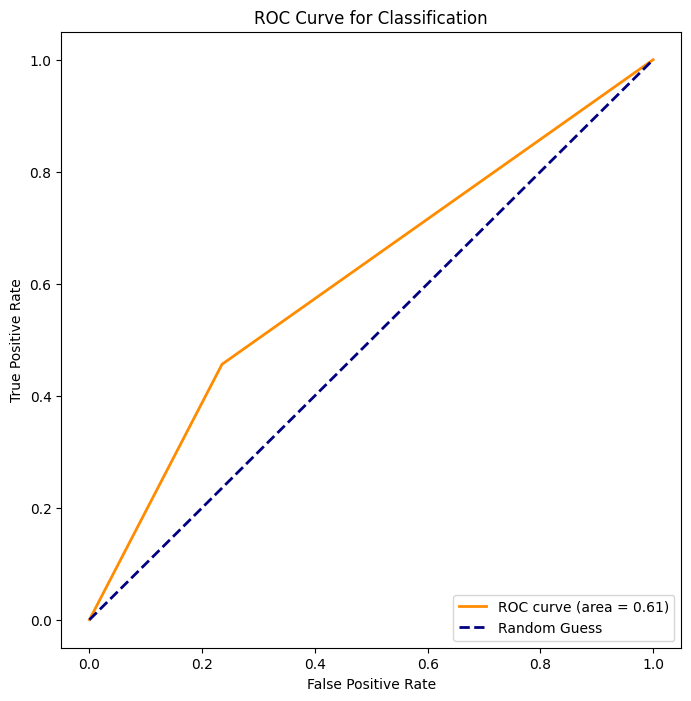

0.7564346790313721

In [ ]:
evaluate(model=SubGGrp_model, test_loader=test_loader_Grp)

In [ ]:
class NodeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NodeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
class EdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(EdgeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class GrpClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GrpClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
node_features = X_train_Node
edge_features = X_train_tensor_e
Grp_features =Grp_X_train
node_labels = y_train_Node
edge_labels = y_train_tensor_e
Grp_labels = Grp_y_train

In [ ]:
# Initialize models
node_classifier = NodeClassifier(input_dim=node_features.shape[1], hidden_dim=128, output_dim=2)
Grp_classifier = GrpClassifier(input_dim=Grp_features.shape[1], hidden_dim=128, output_dim=2)
edge_classifier = EdgeClassifier(input_dim=edge_features.shape[1], hidden_dim=64, output_dim=2)


In [ ]:
node_criterion = nn.CrossEntropyLoss(weight=n_class_weights)
Grp_criterion = nn.CrossEntropyLoss(weight=Grp_class_weights)
edge_criterion = nn.CrossEntropyLoss(weight=e_class_weights)

In [ ]:
optimizer = optim.Adam(list(node_classifier.parameters()) + list(Grp_classifier.parameters()) + list(edge_classifier.parameters()), lr=0.1)

In [ ]:
# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    node_logits = node_classifier(node_features)
    Grp_logits = Grp_classifier(Grp_features)
    edge_logits = edge_classifier(edge_features)

    # Compute losses
    node_loss = node_criterion(node_logits, node_labels)
    Grp_loss = node_criterion(Grp_logits, Grp_labels)
    edge_loss = edge_criterion(edge_logits, edge_labels.long())

    # Total loss (you can weight the losses if needed)
    total_loss = node_loss + edge_loss + Grp_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Node Loss: {node_loss.item()}, Edge Loss: {edge_loss.item()}')

Epoch 1/100, Node Loss: 0.7007476687431335, Edge Loss: 0.6994136571884155
Epoch 6/100, Node Loss: 0.7411178946495056, Edge Loss: 1.107591986656189
Epoch 11/100, Node Loss: 0.6987518072128296, Edge Loss: 0.718412458896637
Epoch 16/100, Node Loss: 0.6950927972793579, Edge Loss: 0.6830258369445801
Epoch 21/100, Node Loss: 0.6854108572006226, Edge Loss: 0.6814351081848145
Epoch 26/100, Node Loss: 0.6847144961357117, Edge Loss: 0.6812490820884705
Epoch 31/100, Node Loss: 0.683143138885498, Edge Loss: 0.6809812188148499
Epoch 36/100, Node Loss: 0.6826592683792114, Edge Loss: 0.6804746389389038
Epoch 41/100, Node Loss: 0.6814199090003967, Edge Loss: 0.6802200675010681
Epoch 46/100, Node Loss: 0.680841326713562, Edge Loss: 0.6802020072937012
Epoch 51/100, Node Loss: 0.6806012392044067, Edge Loss: 0.6801195740699768
Epoch 56/100, Node Loss: 0.679592490196228, Edge Loss: 0.6800472736358643
Epoch 61/100, Node Loss: 0.6789810061454773, Edge Loss: 0.6798875331878662
Epoch 66/100, Node Loss: 0.67854

              precision    recall  f1-score   support

           0       0.99      0.83      0.91     12889
           1       0.01      0.23      0.02        74

    accuracy                           0.83     12963
   macro avg       0.50      0.53      0.46     12963
weighted avg       0.99      0.83      0.90     12963



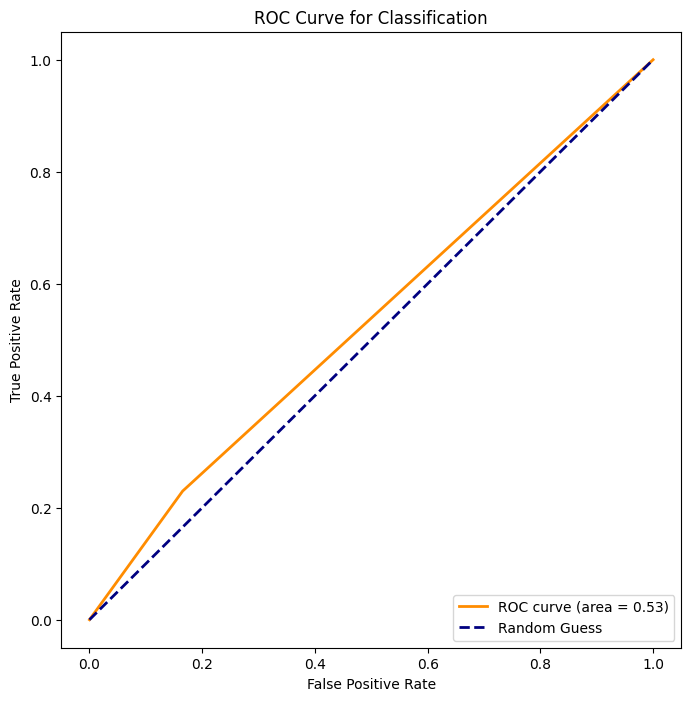

(0.8312119245529175, tensor([1, 1, 1,  ..., 0, 1, 0]))

In [ ]:
evaluate(model=node_classifier, test_loader=test_loader_node)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12948
           1       0.00      0.00      0.00         6

    accuracy                           1.00     12954
   macro avg       0.50      0.50      0.50     12954
weighted avg       1.00      1.00      1.00     12954



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


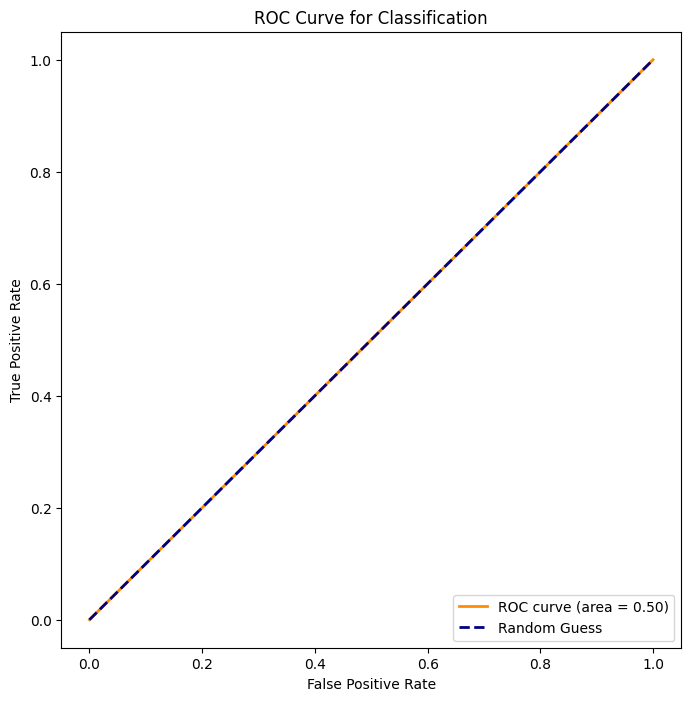

(0.9995368123054504, tensor([0, 0, 0,  ..., 0, 0, 0]))

In [ ]:
evaluate(model=Grp_classifier, test_loader=test_loader_Grp)


              precision    recall  f1-score   support

         0.0       1.00      0.14      0.25     16196
         1.0       0.00      0.88      0.00        26

    accuracy                           0.14     16222
   macro avg       0.50      0.51      0.13     16222
weighted avg       1.00      0.14      0.25     16222



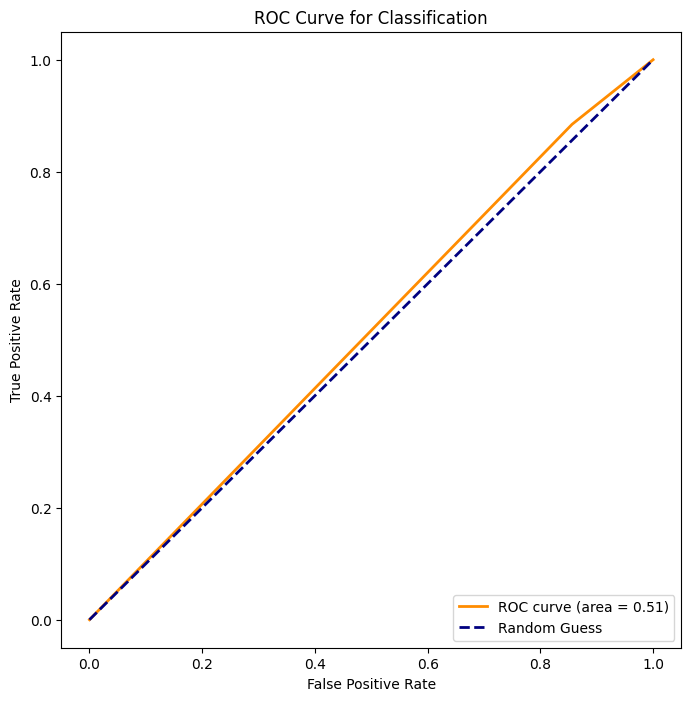

(0.1449882835149765, tensor([1, 1, 1,  ..., 1, 1, 1]))

In [ ]:
evaluate(model=edge_classifier, test_loader=test_loader_e)

# Create Model and Method

In [ ]:
class Classifier(nn.Module):
    def __init__(self, encoder):
        super(Classifier, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(8, 2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        return x


In [ ]:
def evaluate(model,test_loader):
    torch.backends.cudnn.deterministic = True
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            logits = model(inputs)
            _, predicted = torch.max(logits, 1)

            accuracy = (predicted == labels).float().mean().item()


        print(classification_report(labels, predicted))

    #--------------------Plot AUC----------------------------
        fpr, tpr, thresholds = roc_curve(labels, predicted)

        # Calculate the AUC
        roc_auc = auc(fpr, tpr)
        # Calculate the AUC
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Classification')
        plt.legend(loc='lower right')
        plt.show()

    return accuracy

In [ ]:
def train (model,train_loader , epochs , class_weights , learning_rate):
    torch.backends.cudnn.deterministic = True
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_list: list = []
    # Training loop
    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            loss_list.append(loss.item())
            loss.backward()
            optimizer.step()

        #print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        if epoch % 5 == 0:
            print(f"In epoch {epoch}, loss: {loss:.3f})"
                )
    plt.plot(loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Chart')
    plt.show()
    return model

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
def Get_class_weights(data):
    class_labels=torch.unique(data)
    class_labels=np.array(class_labels)
    y=np.array(data)
    class_weight =compute_class_weight(class_weight='balanced', classes=class_labels, y=y)
    class_weights=torch.tensor(class_weight ,  dtype = torch.float)
    return class_weights


# Model For Multi Task Learning

In [ ]:
class SubClassifier(nn.Module):
    def __init__(self, encoder):
        super(SubClassifier, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(16, 2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        return x


class GrpSub_Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(GrpSub_Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            #nn.Linear(64, 32),
            #nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            #nn.Linear(32, 64),
            #nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()  # Sigmoid for output between 0 and 1
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
class LpClassifier(nn.Module):
    def __init__(self, encoder):
        super(LpClassifier, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(8, 2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        return x
class GrpLp_Autoencoder(nn.Module):
    def __init__(self,input_dim):
        super(GrpLp_Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            #nn.Linear(64, 32),
            #nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            #nn.Linear(32, 64),
            #nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()  # Sigmoid for output between 0 and 1
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
class FIClassifier(nn.Module):
    def __init__(self, encoder):
        super(FIClassifier, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(16, 2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        return x

class GrpFI_Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(GrpFI_Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            #nn.Linear(64, 32),
            #nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            #nn.Linear(64, 32),
            #nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()  # Sigmoid for output between 0 and 1
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
len(GrpLP_y_train)

13767

In [ ]:
Col_Feature_sub=['subgraph_embedding_0','subgraph_embedding_1']
F_TST_df=Feature_test_df[Col_Feature_sub]
Grpsub_X_test=torch.tensor(F_TST_df.values.tolist(), dtype=torch.float)
Grpsub_y_test=torch.tensor((Feature_test_df['Label'].values).tolist(), dtype=torch.long)

F_TR_df=Feature_train_df[Col_Feature_sub]
Grpsub_X_train=torch.tensor(F_TR_df.values.tolist(), dtype=torch.float)
Grpsub_y_train=torch.tensor((Feature_train_df['Label'].values).tolist(), dtype=torch.long)
#-------------------------------------------------------------------------------------------
Col_Feature_Final=['f_amount_in','f_amount_out']
F_TST_df=Feature_test_df[Col_Feature_Final]
GrpFI_X_test=torch.tensor(F_TST_df.values.tolist(), dtype=torch.float)
GrpFI_y_test=torch.tensor((Feature_test_df['Label'].values).tolist(), dtype=torch.long)

F_TR_df=Feature_train_df[Col_Feature_Final]
GrpFI_X_train=torch.tensor(F_TR_df.values.tolist(), dtype=torch.float)
GrpFI_y_train=torch.tensor((Feature_train_df['Label'].values).tolist(), dtype=torch.long)
#--------------------------------------------------------------------------------------------
Col_Feature_LP=['embedded_Laplacian_0','embedded_Laplacian_1']
F_TST_df=Feature_test_df[Col_Feature_LP]
GrpLP_X_test=torch.tensor(F_TST_df.values.tolist(), dtype=torch.float)
GrpLP_y_test=torch.tensor((Feature_test_df['Label'].values).tolist(), dtype=torch.long)

F_TR_df=Feature_train_df[Col_Feature_LP]
GrpLP_X_train=torch.tensor(F_TR_df.values.tolist(), dtype=torch.float)
GrpLP_y_train=torch.tensor((Feature_train_df['Label'].values).tolist(), dtype=torch.long)


In [ ]:
G_class_weights=Get_class_weights(Grpsub_y_train)
batch_size_TR= len(Grpsub_X_train)
batch_size_TST= len(Grpsub_X_test)

In [ ]:
Sub_learning_rate=0.09
train_dateset=torch.utils.data.TensorDataset(Grpsub_X_train,Grpsub_y_train)
train_loader_subGrp=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_TR, shuffle=True)
test_dataset=torch.utils.data.TensorDataset(Grpsub_X_test,Grpsub_y_test)
test_loader_subGrp=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_TST, shuffle=False )
#----------------------------------------------------
FI_learning_rate=0.003
train_dateset=torch.utils.data.TensorDataset(GrpFI_X_train,GrpFI_y_train)
train_loader_FIGrp=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_TR, shuffle=True)
test_dataset=torch.utils.data.TensorDataset(GrpFI_X_test,GrpFI_y_test)
test_loader_FIGrp=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_TST, shuffle=False )
#----------------------------------------------------
LP_learning_rate=0.2
train_dateset=torch.utils.data.TensorDataset(GrpLP_X_train,GrpLP_y_train)
train_loader_LPGrp=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_TR, shuffle=True)
test_dataset=torch.utils.data.TensorDataset(GrpLP_X_test,GrpLP_y_test)
test_loader_LPGrp=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_TST, shuffle=False )



In [ ]:
Grpsub_X_train.shape[1]

2

In [ ]:
autoencoder = GrpSub_Autoencoder(input_dim=Grpsub_X_train.shape[1])
GrpSub_classifier = SubClassifier(autoencoder.encoder )

autoencoder = GrpFI_Autoencoder(input_dim=GrpFI_X_train.shape[1])
GrpFI_classifier = FIClassifier(autoencoder.encoder)

autoencoder = GrpLp_Autoencoder(input_dim=GrpLP_X_train.shape[1])
GrpLpclassifier = LpClassifier(autoencoder.encoder)


In [ ]:
criterion = nn.CrossEntropyLoss(weight=G_class_weights)

In [ ]:
#optimizer = optim.Adam(list(GrpSub_classifier.parameters()) + list(GrpFI_classifier.parameters()) + list(GrpLpclassifier.parameters()), lr=0.07)
optimizer = optim.Adam(list(GrpSub_classifier.parameters()) + list(GrpLpclassifier.parameters()) , lr=0.07)

In [ ]:
# Training loop
torch.backends.cudnn.deterministic = True
epochs = 80
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    GrpSub_logits = GrpSub_classifier(Grpsub_X_train)
    GrpFI_logits = GrpFI_classifier(GrpFI_X_train)
    GrpLp_logits = GrpLpclassifier(GrpLP_X_train)

    # Compute losses
    GrpSub_loss = criterion(GrpSub_logits, Grpsub_y_train)
    #GrpFI_loss = criterion(GrpFI_logits, GrpFI_y_train)
    GrpLp_loss = criterion(GrpLp_logits, GrpLP_y_train)

    # Total loss (you can weight the losses if needed)
    total_loss = GrpSub_loss + GrpLp_loss
    loss_mean = torch.mean(total_loss)
    # Backpropagation
    #total_loss.backward()
    loss_mean.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}, SubGraph Loss: {GrpSub_loss.item()}, FI Loss: {GrpFI_loss.item()} , LP Loss: {GrpLp_loss.item()}')

Epoch 1/80, SubGraph Loss: 0.6218695044517517, FI Loss: 0.6931472420692444 , LP Loss: 0.6057228446006775
Epoch 6/80, SubGraph Loss: 0.6479236483573914, FI Loss: 0.6931472420692444 , LP Loss: 0.6158574819564819
Epoch 11/80, SubGraph Loss: 0.6354581713676453, FI Loss: 0.6931472420692444 , LP Loss: 0.6099659204483032
Epoch 16/80, SubGraph Loss: 0.6331208944320679, FI Loss: 0.6931472420692444 , LP Loss: 0.6067715883255005
Epoch 21/80, SubGraph Loss: 0.6255561113357544, FI Loss: 0.6931472420692444 , LP Loss: 0.6039458513259888
Epoch 26/80, SubGraph Loss: 0.6225571632385254, FI Loss: 0.6931472420692444 , LP Loss: 0.6017563939094543
Epoch 31/80, SubGraph Loss: 0.6232227683067322, FI Loss: 0.6931472420692444 , LP Loss: 0.6009964942932129
Epoch 36/80, SubGraph Loss: 0.6271392107009888, FI Loss: 0.6931472420692444 , LP Loss: 0.6004971265792847
Epoch 41/80, SubGraph Loss: 0.6232098937034607, FI Loss: 0.6931472420692444 , LP Loss: 0.6047139763832092
Epoch 46/80, SubGraph Loss: 0.6215105652809143, 

              precision    recall  f1-score   support

           0       0.98      0.71      0.82      2041
           1       0.05      0.54      0.09        57

    accuracy                           0.70      2098
   macro avg       0.52      0.63      0.46      2098
weighted avg       0.96      0.70      0.80      2098



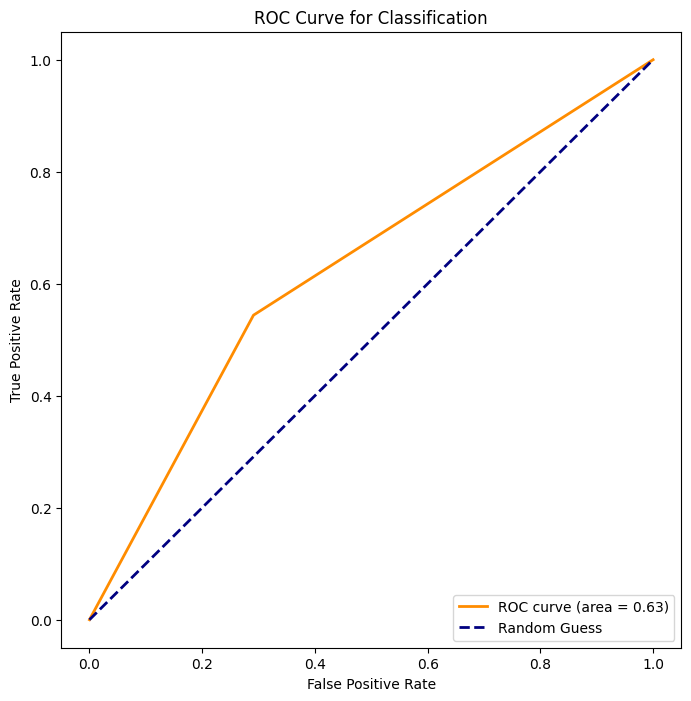

0.7044804692268372

In [ ]:
evaluate(model=GrpSub_classifier, test_loader=test_loader_subGrp)

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      2041
           1       0.07      0.26      0.11        57

    accuracy                           0.88      2098
   macro avg       0.52      0.58      0.52      2098
weighted avg       0.95      0.88      0.92      2098



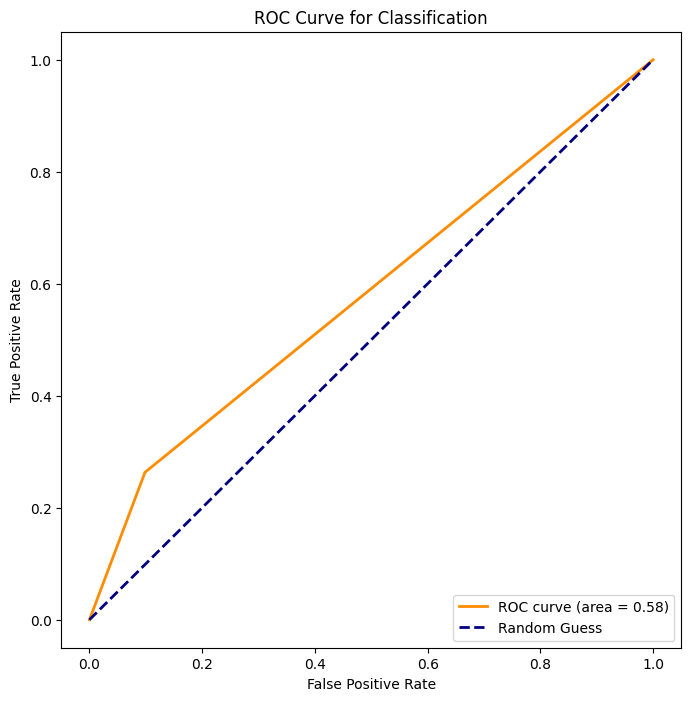

0.8841754198074341

In [ ]:
evaluate(model=GrpLpclassifier, test_loader=test_loader_LPGrp)